**motivation** <br>
Last December I saw a Christmas wreath while walking in the neighborhood. It reminded me of a middle aged man I met years ago in Bentonville Arkansas, selling Christmas wreaths door to door. He said he was injuried at work, his wife made those to earn some extra cash for the kids. How did my sight of the Christmas wreath activate my memory? The Hopfield net models memory retrieval as an iterative process of a dynamical system settling down to its energy minima. When I first learned about this in Geoffrey Hinton's Coursera course <i> Neural Networks for Machine Learning </i> I was immediately captivated. In this notebook I want to play with a simple Hopfield net. The code is sourced from 
<a href="http://codeaffectionate.blogspot.com/2013/05/fun-with-hopfield-and-numpy.html">this post</a> by Stefan Maetschke and <a href="https://github.com/tomstafford/emerge/blob/master/lecture4.ipynb">this notebook</a> by Tom Stafford. 

In [1]:
import numpy as np
from numpy import array
from numpy import zeros, outer, diag_indices, vectorize, dot 
from pylab import imshow, cm, show
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
A = """
.XXX.
X...X
XXXXX
X...X
X...X
"""
 
Z = """
XXXXX
...X.
..X..
.X...
XXXXX
"""

In [3]:
def to_pattern(letter):
    '''
    hopfield nets operate on binary vectors
    transform a letter into a binary vector
    '''
    return array([+1 if c=='X' else -1 for c in letter.replace('\n','')])

In [4]:
def display(pattern):
    '''
    visualize a pattern as an image
    '''
    imshow(pattern.reshape((5,5)),cmap=cm.binary, interpolation='nearest')
    show()

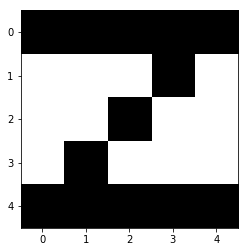

In [5]:
display(to_pattern(Z))

In [6]:
# collect two patterns together
patterns = np.array([to_pattern(A), to_pattern(Z)]) # patterns have shape 2 x 25

**Understand what is a hopfield network**

- Basic ingredient: A set of patterns, where each pattern is a binary vector of fixed length $L$ (in the example $L$=25)
- A hopfield network is just an $L$ x $L$ matrix $W$, which represents a network of $L$ nodes (corresponding to the $L$ pixels in each pattern), where the edge between two nodes $i$ and $j$ is weighted by $W_{ij}$.
- A hopfield network stores the patterns for later retrieval. Instead of storing the patterns literally as they are, a hopfield net instead stores a network of pixels as an $L$ x $L$ weight matrix, where $L$ is the number of pixels in each pattern.

In [7]:
def train(patterns):
    '''
    for each pattern in patterns, do outer product; add these outer products, set diagonal terms to 0, then average
    '''
    r,c = patterns.shape
    W = zeros((c,c))
    for p in patterns:
        W = W + outer(p,p)
    W[diag_indices(c)] = 0
    return W/r

**How to recall a stored pattern from a hopfield net?**<br>
To query a hopfield net W with a pattern p is first to dot product p with W, then squash the result into a binary vector, then iterate the dot product and the squash a number of steps

In [8]:
def recall(W, patterns, steps=1):
    '''
    W: a hopfield net
    patterns: a set of patterns, each pattern is a fixed length binary vector
    steps: number of iterations
    return stored patterns
    '''
    sgn = vectorize(lambda x: -1 if x<0 else +1)
    for _ in range(steps):        
        patterns = sgn(dot(patterns,W))
    return patterns

**Now let's test our HN with some noisy patterns**

In [9]:
def degrade(patterns,noise,seed=None):
    '''
    patterns: a set of patterns, to be made noisy
    noise: the probability with which each pixel will be flipped
    return: noisy patterns
    '''
    random.seed(seed)
    sgn=np.vectorize(lambda x: x*-1 if random.random()<noise else x)
    out=sgn(patterns)
    return out

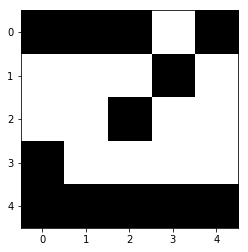

In [10]:
# when I added a little bit noise, it looks like this:
noisy_pattern = degrade(to_pattern(Z), 0.1)
display(noisy_pattern)

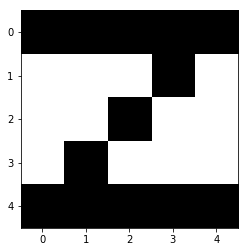

In [11]:
# now is my HN able to recognize the noisy pattern?
# yes! I've seen one instance where it failed, but for the most part it succeeded!
W = train(patterns)
display(recall(W, noisy_pattern, steps=5))

**Energy**<br>
patterns stored as low energy states, the iterative process in recall is to trace the trajectory of an input pattern to its attractor. for a given pattern $p$ and a hopfield net $W$, the energy of $p$ is $$E(p) = pWp^T$$

In [12]:
def hopfield_energy(W, patterns):
    '''
    W: a hopfield net
    patterns: a collection of patterns, where each pattern is a fixed length binary vector
    return: energy of each pattern in patterns
    '''
    return array([-0.5*dot(dot(p.T,W),p) for p in patterns])

In [13]:
# test the energy function using a noisy A
# in this test when seed = 7, it triggered the wrong memory!
# when seed = 11, it triggered the right memory after two steps!
steps = 5
noisy_A = degrade(to_pattern(A), 0.3, seed = 11)
sgn = vectorize(lambda x: -1 if x<0 else +1)
a = noisy_A
for _ in range(steps):        
    print(hopfield_energy(W, [a]))
    a = sgn(dot(a,W))

[-6.]
[-50.]
[-150.]
[-150.]
[-150.]


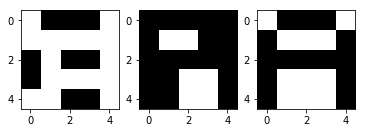

In [14]:
# visualize memory retrieval
patterns = [noisy_A, recall(W, noisy_A, steps=1), recall(W, noisy_A, steps=2)]
f,ax = plt.subplots(1,len(patterns))
for i in range(len(patterns)):
    ax[i].imshow(patterns[i].reshape((5,5)),cmap=cm.binary, interpolation='nearest')
plt.show() 

In [15]:
def f(noise, W):
    '''
    noise: the probability with which each pixel will be flipped
    W: a hopfield net
    return: the energy of a noisy pattern
    '''
    p = degrade(to_pattern(A), noise)
    return hopfield_energy(W, [p])

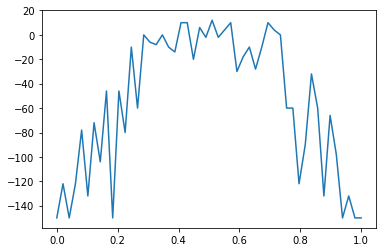

In [16]:
# notice that noise is loudest when noise = 0.5, when noise is low (noise close to 0 or 1), energy of pattern is low
x = np.linspace(0, 1, num=50).tolist()
y = [f(z, W) for z in x]
plt.plot(x, y)

**what happens when you feed my HN with a flipped A?**<br>
it returns a flipped A as well! and when you feed my HN with an imperfect flipped A, it will return a perfect flipped A!

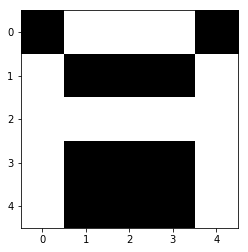

In [17]:
noisy_A = degrade(to_pattern(A), 1)
display(noisy_A)

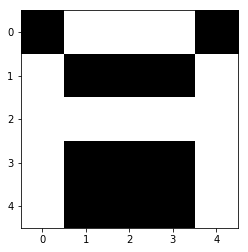

In [18]:
display((recall(W, noisy_A, steps=5)))

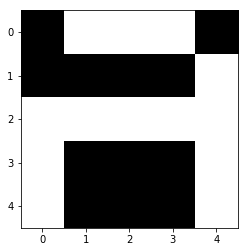

In [19]:
noisy_A = degrade(to_pattern(A), 0.9)
display(noisy_A)

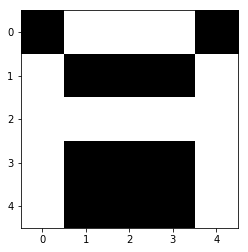

In [20]:
display((recall(W, noisy_A, steps=5)))

**Discussion**<br><br>
Underlying a hopfield net is a dynamical system. The ingredients of this system are as follows:
1. state: in our case a state is a pattern, it's a binary vector of fixed length
2. law of motion for states: for a given input pattern $p$, the output pattern is $sgn(pW)$, where the sign function and the $W$ matrix is defined earlier in this notebook. $W$ is also known as the hopfield net, because it defines a weighted network with the pixels as nodes.
3. a Lyapunov function $E(p) = pWp^T$, such that as the states evolve according to the law of motion in 2, the value of $E(p)$, or energy, cannot go up.
4. memories are thus modeled as energy minima in this dynamical system.